# Corporate and institutional ties (Fig. 2 and Fig. 3)

## Setup

In [19]:
# Imports
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# Load data
eras = [[2008, 2009],[2018, 2019]]
all_papers = pd.read_excel('../data/affiliations_and_funding_ties.xlsx', sheet_name="Papers Ties")
orgs = pd.read_excel('../data/affiliations_and_funding_ties.xlsx', sheet_name='Orgs')
all_university_affils = pd.read_csv('../data/university_affiliations.tsv', sep='\t')
results_dirname = '../results/'

# Process data
eras_papers = [all_papers[all_papers.YEAR.isin(era)] for era in eras]
big_tech_orgs = list(orgs[orgs['BIG TECH'] == 'x']['ORG'])
eras_university_affils = [all_university_affils[all_university_affils.Year.isin(era)] for era in eras]
eras = ['-'.join([str(year) for year in era]) for era in eras]

## Figure 2: Corporate affiliations

In [20]:
def has_big_tech_affiliation(row):
    return any([(row[f'Affil: {org}']>0) for org in big_tech_orgs if (f'Affil: {org}' in row)])

all_affils = []
for i, (era, papers) in enumerate(zip(eras, eras_papers)):
    affils = pd.DataFrame(columns=['Era', 'Category', 'Fraction'])
    affils.Category = ['Big Tech affiliation', 'Other corporate affiliation', 'No corporate affiliation']
    affils.Era = era
    affils.Fraction = [len(papers[papers.apply(has_big_tech_affiliation, axis=1)]) / len(papers),
                       len(papers[(papers['CLEANED CORPORATE AFFILIATION'] != 'NONE STATED') & ~(papers.apply(has_big_tech_affiliation, axis=1))]) / len(papers),
                       1-(len(papers[papers['CLEANED CORPORATE AFFILIATION'] != 'NONE STATED']) / len(papers))]
    all_affils.append(affils)
pd.concat(all_affils).rename(dict(Fraction='Fraction of era\'s papers'), axis=1).to_csv(results_dirname + 'corporate_affiliations.csv', index=False)

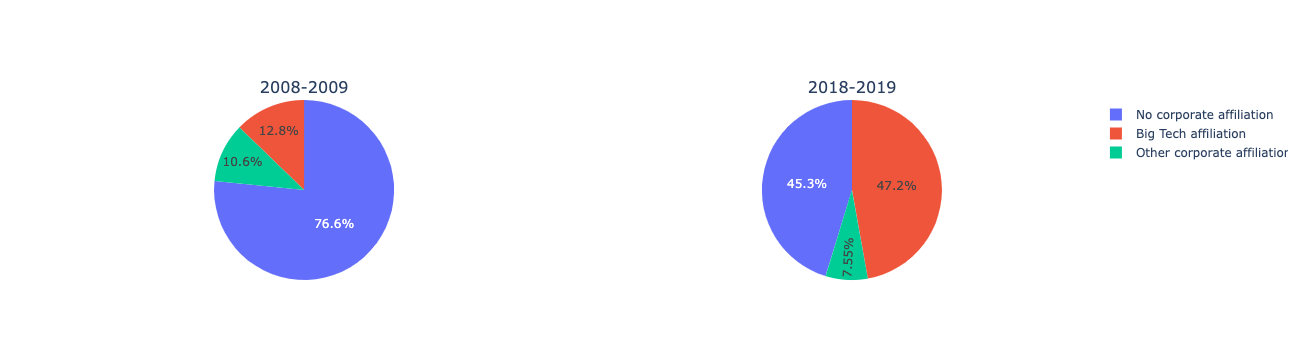

In [21]:
fig = make_subplots(rows=1, cols=2, subplot_titles=eras, specs=[[{"type": "pie"}, {"type": "pie"}]])
fig.add_traces(data=[px.pie(affils, names='Category', values='Fraction', title=i).data[0] for i, affils in enumerate(all_affils)], rows=1, cols=[1,2])
fig.write_image(results_dirname + 'corporate_affiliations.png')
fig

## Figure 3: Institutional ties

In [22]:
all_institutional_ties = pd.DataFrame()
for era, papers, university_affils in zip(eras, eras_papers, eras_university_affils):
    university_categories = ['Any University Affiliation', 'Elite University Affiliation (2018)', 'Non-NA University Affiliation']
    university_counts = [university_affils[cat].sum() / len(university_affils) for cat in university_categories]
    other_categories = ['AGENCIES', 'MILITARY', 'NONPROFIT FUNDER', 'RESEARCH INSTITUTE', 'TECH COMPANY', 'BIG TECH']
    other_counts = [len(papers[papers[cat] > 0]) / len(papers) for cat in other_categories]
    institutional_ties = pd.DataFrame(dict(Era=str(era), Category=university_categories+other_categories, Fraction=university_counts+other_counts))
    all_institutional_ties = pd.concat([all_institutional_ties, institutional_ties], ignore_index=True)
all_institutional_ties.rename(dict(Fraction='Fraction of era\'s papers'), axis=1).to_csv(results_dirname + 'institutional_ties.csv', index=False)

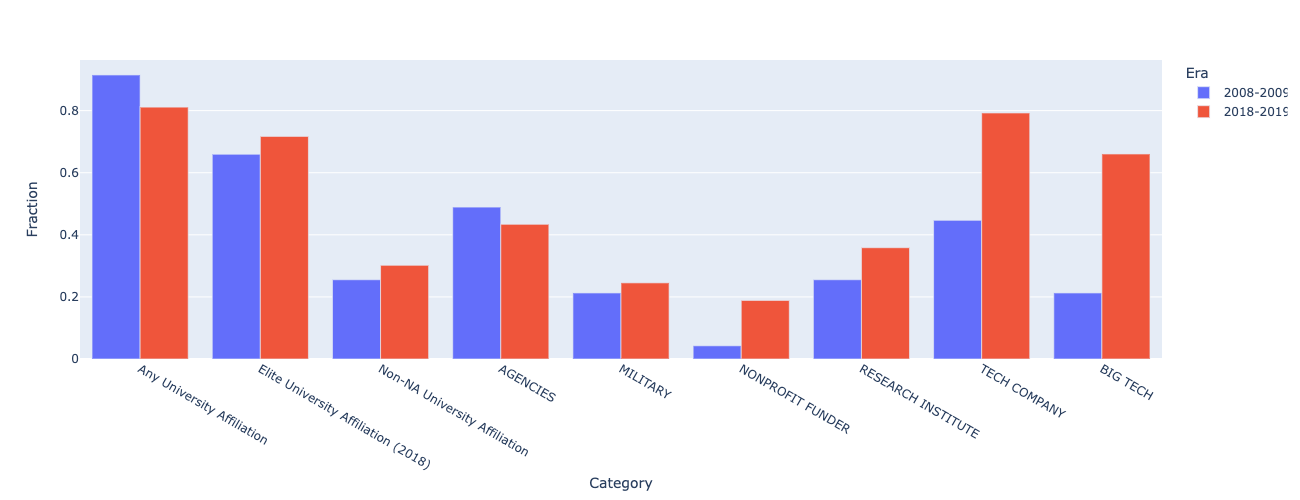

In [23]:
fig = px.bar(all_institutional_ties, x='Category', y='Fraction', labels=dict(count='Percent of papers', era='', category=''), width=800, height=500, color='Era', barmode='group')
fig.write_image(results_dirname + 'institutional_ties.png')
fig